<a href="https://colab.research.google.com/github/JarvisSan22/JC_Learn_Detectron2/blob/main/Detectron2_TACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Detectron2 Set up

In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 52.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 13.9 MB/s 
  Created wheel f

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 1.6 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=02e539eeb7a59006f5985441e28a9cd2941cf8d028c39b305c2915c1ebe17b62
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore


# Taco dataset set up

In [ ]:
!git clone https://github.com/pedropro/TACO.git
!cd TACO
!python3 TACO/download.py --dataset_path TACO/data/annotations.json

fatal: destination path 'TACO' already exists and is not an empty directory.
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished


# Imports 

In [ ]:
import numpy as np
import os
from tqdm import tqdm
import os, json, cv2, random
import pandas as pd
import matplotlib.pyplot as plt
import copy
plt.rcParams.update({'font.size': 22})

# Taco dataset read and viewing 

In [ ]:
dataset_path = './TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)

In [ ]:
img_df=pd.DataFrame(imgs)
ang_df=pd.DataFrame(anns)
cat_df=pd.DataFrame(categories)
print('Number of super categories:',len(cat_df.supercategory.unique()))
print('Number of categories:',len(cat_df.name.unique()))
print('Number of annotations:', len(ang_df))
print('Number of images:', len(img_df))

img_df.head()

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...


In [ ]:
#Cut duplicates 
val,counts=np.unique(ang_df.id,return_counts=True)
val[counts>1] 

array([ 309, 4040])

In [ ]:
ang_df[ang_df.id.duplicated()]

,id,image_id,category_id,segmentation,area,bbox,iscrowd
309,309,101,5,"[[1410, 1396, 1552, 1349, 1610, 1346, 1623, 13...",26957.0,"[1370.0, 1291.0, 380.0, 150.0]",0
4040,4040,1300,58,"[[143, 1979, 187, 1980, 184, 2028, 158, 2028, ...",1798.5,"[143.0, 1979.0, 44.0, 49.0]",0


In [ ]:
ang_df=ang_df[~ang_df.id.duplicated(keep="first")]

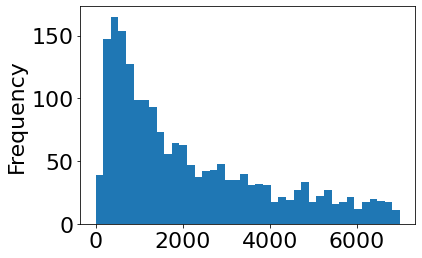

In [ ]:
ang_df["area"].plot.hist(range=(0,7000),bins=40)

In [1]:
import colorsys
from ipywidgets import interact  

def get_optimal_font_scale(text, width): 
    #Source https://stackoverflow.com/questions/52846474/how-to-resize-text-for-cv2-puttext-according-to-the-image-size-in-opencv-python

    for scale in reversed(range(0, 60, 1)):
      textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=scale/10, thickness=1)
      new_width = textSize[0][0]
      #print(new_width)
      if (new_width <= width):
          return scale/10
    return 1



def CV2_SegBBoxClassImshow(image,n_bbox,n_segs,n_classes,ax=None,bbox_type="XYWH",figsize=(10,10)):
    #Add to subplot or create new plot 
    if not ax:
        fig,ax=plt.subplots(1,1,figsize=figsize)
    #copy image, make sure its an array 
    new_image=np.array(image)
 
    
    #Add bbox and segmentations in look  
    for box,seg,cat in zip(n_bbox,n_segs,n_classes):
      
        c=colorsys.hsv_to_rgb(np.random.random(),1,255)
        
        #print(c)
        # = ( int (c [ 0 ]), int (c[ 1 ]), int (c [ 2 ])) 
        box=np.array(box,dtype=np.int32)
        #bbox type XXWH
        if bbox_type=="XYWH": #(x0,y0,w,h)
            new_image=cv2.rectangle(new_image,
                        (box[0],box[1]),
                        (box[0]+box[2],box[1]+box[3]),
                        c,
                        thickness=5
                        )
        else: #XYXY
            new_image=cv2.rectangle(new_image,
                         (box[0],box[1]),
                        (box[2],box[3]),
                        c,
                        thickness=5
                        )
       
        pl=len(seg)
        #ALpha effect for fillpoly 
        seg=np.array(seg,dtype=np.uint64).reshape(1, -1, 2)
        overlay=new_image.copy()
        cv2.fillPoly(overlay,seg,c) #Add segmentation
        
        scale=get_optimal_font_scale(cat, box[2]) #Text scaling to BBox width 
        cv2.putText(new_image,cat, (box[0],box[1]),cv2.FONT_HERSHEY_PLAIN, scale,c,cv2.LINE_AA)


        new_image=cv2.addWeighted(overlay,0.4,new_image,1-0.4,0)
    
        
    #Show image 
    ax.imshow(new_image[:,:,::-1])
    ax.set_title(f"image {new_image.shape}, BBoxs {len(n_bbox)}")
    
   

    
  
data_dic=dataset
#Interactive plot by images id 
@interact(image_idx=(0, len(data_dic["images"])))
def DataDict_intract_view(image_idx):
    img_d=data_dic["images"][image_idx]
    id=img_d["id"]
    
    img=cv2.imread(dataset_path+"/"+img_d["file_name"]) #Read image 

    #Get annotations 
    annot=list([ a for a in data_dic["annotations"] if a["image_id"]==id ])
    #segs=np.array(list([a["segmentation"] for a in annot]))
    n_bbox=list([a["bbox"] for a in annot])
    n_segs=list([a['segmentation'] for a in annot])
    #n_classes=list([a['category_id'] for a in annot])
    #Class names
    n_classes=[ cat_df.iloc[annot[i]["category_id"]].supercategory for i in range(0, len(annot))]
    #print(n_bbox)
    CV2_SegBBoxClassImshow(img,n_bbox,n_segs,n_classes,bbox_type="XYWH")    

NameError: ignored

# Taco Dataset to COCO 

Format data ready for detectron
* category ids -> super catergorys
* add bbox type
* create json from train and evaluations
* Save as COCO dataset

In [ ]:
#Super catergoires
ang_df["super_category"]=ang_df["category_id"].apply(lambda value: categories[value]["supercategory"] )
super_categorys=[]
ang_df["super_category_id"]=0
for i,cat in enumerate(sorted(ang_df["super_category"].unique())):
    super_categorys.append({"name":cat,"id":i})
    ang_df.loc[ang_df["super_category"]==cat,"super_category_id"]=i
ang_df["category_id"]=ang_df["super_category_id"]

In [ ]:
#BBOx mode
from detectron2.structures import BoxMode

ang_df["bbox_mode"]=BoxMode.XYWH_ABS


cocodata={"images":img_df[["id","width","height","file_name"]].to_dict("records"),#Cut index 
         "annotations":ang_df[['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox',
       'iscrowd', 'bbox_mode']].to_dict("records"),
          "categories":super_categorys, "info":dataset["info"]}


In [ ]:
#Save datadata as json
save_name="TACO_annotations.json"
json.dump(cocodata,open(save_name,"w"))


#Train eval split
img_id=list(range(1,len(cocodata["images"])+1))
np.random.seed=42
import random


def SplitDatadir(data_dict,img_ids):
    newdata_dict=copy.deepcopy(data_dict) #.copy()
    print("start",len(newdata_dict["images"]),len(newdata_dict["annotations"]))
    #newdata_dict["images"]={}
    #newdata_dict["annotations"]={}
    newdata_dict["images"]=list(img for img in data_dict["images"] if img["id"] in img_ids)
    
    newdata_dict["annotations"]=list(ann for ann in data_dict["annotations"] if ann['image_id'] in img_ids)
    
    print("finish",len(newdata_dict["images"]),len(newdata_dict["annotations"]))
    return newdata_dict

#Split data set by 80% train, 20% eval
train_id=random.sample(img_id,int((len(img_id))*0.8))
val_id=list([id for id in img_id if id not in train_id])
print(len(train_id),len(val_id))

train_dataset=SplitDatadir(cocodata,train_id)
json.dump(train_dataset,open(save_name.replace(".","_train."),"w"))
val_dataset=SplitDatadir(cocodata,val_id)
json.dump(val_dataset,open(save_name.replace(".","_val."),"w"))

1200 300
start 1500 4782
finish 1200 3763
start 1500 4782
finish 299 1018


In [2]:

#Load data set into COCO
image_root=dataset_path
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
label_paths={
   "train":save_name.replace(".","_train."),
   "val":save_name.replace(".","_val."),
    "all":save_name  #label_path,
}
for d in list(label_paths.keys()):
  dataset_name=f"TACO_{d}"
  if dataset_name in DatasetCatalog.list():
    #DatasetCatalog.remove()
    DatasetCatalog.clear(dataset_name)
  register_coco_instances(dataset_name, {},label_paths[d], image_root)

NameError: ignored

# Detectron2 

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from datetime import datetime

In [ ]:
Models_Segmentation=["COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x", 
        "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x"]

In [ ]:
cfg = get_cfg()
model=Models_Segmentation[7]
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml")) #Get base model
cfg.DATASETS.TRAIN = ("TACO_train",)
cfg.DATASETS.TEST = ("TACO_val",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.OUTPUT_DIR=f"./output/{model}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)   

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model) #Dafulte weighting 

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(super_categorys)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.MAX_ITER =500
cfg.SOLVER.LR_SCHEDULER_NAME= "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
cfg.SOLVER.IMS_PER_BATCH =  4
cfg.SOLVER.STEPS = []
cfg.SOLVER.BASE_LR =0.001 



start=datetime.today()
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
end=datetime.today()
modelruntime=end-start   

print(f"{'X'*20}")
print(f"{'X'*20}")
print(f"{'X'*5} runtime {'X'*6}")
print(modelruntime.__str__())
print(f"{'X'*20}")
print(f"{'X'*20}")

RuntimeError: ignored

In [ ]:
#Evaluate 

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

eval_name="TACO_val"
evaluator=COCOEvaluator(eval_name, ("bbox","segm"), 
                        False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg,eval_name)

evalation=inference_on_dataset(trainer.model, val_loader, evaluator)


In [ ]:
df_evalation=pd.DataFrame(evalation)
df_evalation=df_evalation.drop(["APs","APm","APl"],axis=0)
df_evalation.to_csv(cfg.OUTPUT_DIR+"/evaluation.csv")

fig,ax=plt.subplots(1,1,figsize=(10,10))
df_evalation.plot.bar(rot=90,ax=ax)
ax.grid()
ax.set_ylabel("Average Percision (AP)")
fig.savefig(cfg.OUTPUT_DIR+"/AveragePercion_plot.jpg")


# Predictions

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# create config
cfg = get_cfg()
# below path applies to current installation location of Detectron2
model=Models_Segmentation[7]
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS =  os.path.join("output",model, "model_final.pth")  #"detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
cfg.MODEL.DEVICE = "cpu" # we use a CPU Detectron copy
cfg.MODEL.ROI_HEADS.NUM_CLASSES =28 #num_of_classes
# classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes    
predictor = DefaultPredictor(cfg)
print("Predictor has been initialized.")


In [ ]:
ran_img=np.random.choice(imgs) 
img=cv2.imread(dataset_path +"/"+ran_img["file_name"])
pred_result = predictor(img)
pred_result

In [ ]:
from detectron2.utils.visualizer import Visualizer
v = Visualizer(img)
out = v.draw_instance_predictions(pred_result['instances'])
plt.figure(figsize=(15,15))
fig=plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from ipywidgets import interact  
@interact(image_idx=(0, len(imgs)))
def DataDict_intract_view(image_idx):
    img_dir=imgs[image_idx]
    img=cv2.imread(dataset_path +"/"+img_dir["file_name"])
    pred_result = predictor(img)
    v = Visualizer(img)
    out = v.draw_instance_predictions(pred_result['instances'])
    plt.figure(figsize=(10,10))
    fig=plt.imshow(out.get_image()[:, :, ::-1])